# Cross-contour transport

This notebook calculates the transport across an arbitrary contour. We do this by first creating the contour, such as sea surface height, and extracting the coordinates using `matplotlib`'s `Path` class. We then create some masks to indicate which direction is across the contour at each position along the contour. We then load the transport data and compute the transport, resulting in data with dimensions depth and along contour index. 

Computation times shown used conda environment `analysis3-25.05` on 28 broadwell cpus.

**Alert:** After including the additional cases the contour number doesn't always monotonically increase along the contour. At the moment, the two indices that are set at the same time are adjacent numbers, whereas if you were following the contour you'd expect their numbers to be 2 apart with the other coordinate in between. See  https://github.com/COSIMA/cosima-recipes/issues/383.

First, we load useful packages:

In [1]:
import pandas as pd
import intake
import dask
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
import cmocean

from dask.distributed import Client

catalog = intake.cat.access_nri

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46267 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46267/status,
Dashboard: /proxy/46267/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37539,Workers: 28
Dashboard: /proxy/46267/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:41203,Total threads: 1
Dashboard: /proxy/33457/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:44981,


#### Choose experiment

In [3]:
experiment = '01deg_jra55v13_ryf9091'

start_time = '2170-01-01'
end_time = '2170-12-31'
time_slice = slice(start_time, end_time)

#### Choose a latitude range so the contour fits in the range, but there is not too much extra space. Extra space slows down the computation.

In [4]:
lat_range = slice(-82, -59)

#### We must make sure that this latitude range is so that the t-cells are always south and west of the u-cells.

This is important because the meridional and zonal transports occur on different grids to each other. We can check this by loading the `u`-cell and `t`-cell coordinates. 

We choose this convention so that later on when we create `numpy` grids of where the contour is and in what direction the contour goes.

#### Load quantity we want a contour of, e.g. bathymetry

In [5]:
cat_subset = catalog[experiment]

var_search = cat_subset.search(variable=[
    'ht',  # Load this to access the xt_ocean, yt_ocean coordinates
    'hu',  # Load this to access the xu_ocean, yu_ocean coordinates
    
    # 'xt_ocean', # We could also directly search for the coordinates we're after,
    # 'yt_ocean', # but it's not necessary in this instance
    # 'xu_ocean', # hence, they're commented out.
    # 'yu_ocean',
    ], 
    start_date="2170-04-01, 00:00:00")
darray = var_search.to_dask()
ht = darray['ht'].sel(yt_ocean = lat_range)
hu = darray['hu'].sel(yu_ocean = lat_range) 
ht

<xarray.DataArray 'ht' (yt_ocean: 510, xt_ocean: 3600)> Size: 7MB
dask.array<getitem, shape=(510, 3600), dtype=float32, chunksize=(510, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(510, 900), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(510, 900), meta=np.ndarray>
Attributes:
    long_name:      ocean depth on t-cells
    units:          m
    valid_range:    [-1.e+09  1.e+09]
    cell_methods:   time: point
    standard_name:  sea_floor_depth_below_geoid

#### Choose your desired contour value

In [6]:
contour_depth = 1000 # metres

Plot your data (always good idea `:)`)

Text(0.5, 1.0, 'Ocean depth (m)')

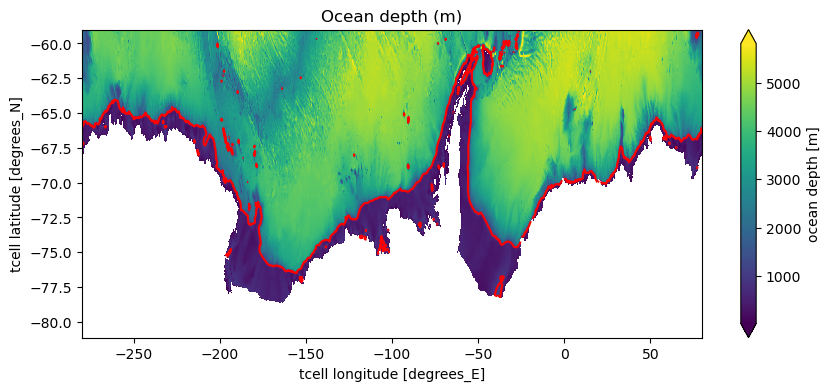

In [7]:
fig = plt.figure(figsize = (10, 4))

ht.plot(extend='both', cbar_kwargs={'label': "ocean depth [m]"})
ht.plot.contour(levels = [contour_depth], colors = 'r', linestyles = '-')
plt.title('Ocean depth (m)')

Fill in land with zeros and load:

In [8]:
ht = ht.fillna(0).load()

Contour is on t-grid (we assume ACCESS-OM2 B-grid transports)

In [9]:
grid_sel = 't'
x_var = ht['xt_ocean']
y_var = ht['yt_ocean']

#### Select the contour 
We need to isolate out the single contour along the slope and get rid of the contours on the little isolated sea mounts and depressions.

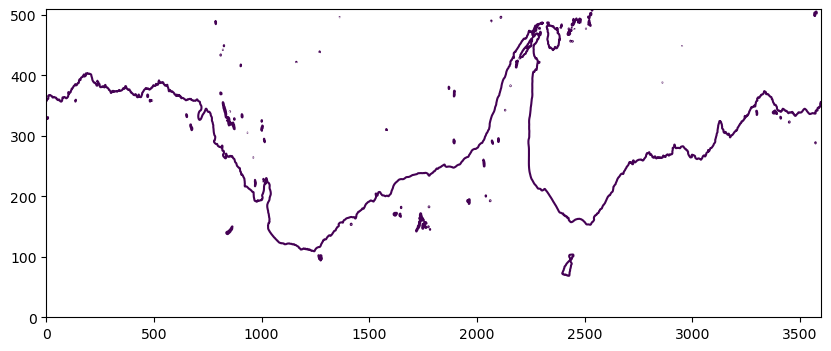

In [10]:
fig = plt.figure(figsize = (10, 4))
sc = plt.contour(ht, levels=[contour_depth])

path_vertices = (sc.get_paths()[0]).vertices
x_vertices = path_vertices[:, 0]
y_vertices = path_vertices[:, 1]

This list of path_vertices includes all of the paths in the above figure. But we want to only select the longest contour. The contours are all stacked in `x_vertices` and `y_vertices`, with the longest contour listed first. We need to find the end of the longest contour and cut `x_vertices`/`y_vertices` at that point.

Along our desired contour, `x_vertices`/`y_vertices` should increase/decrease by max 1, so we can use the location where `diff(x_vertices) > 1` to find the end of our desired contour.

When we call `np.diff`, we wind up with floating point numbers. To get a mask where the difference is greater than 1, we can just turn the result of `np.diff(x_vertices)` back into an array of integers using `.astype(int)` on it - so we can cleanly check if the result is greater than 1.

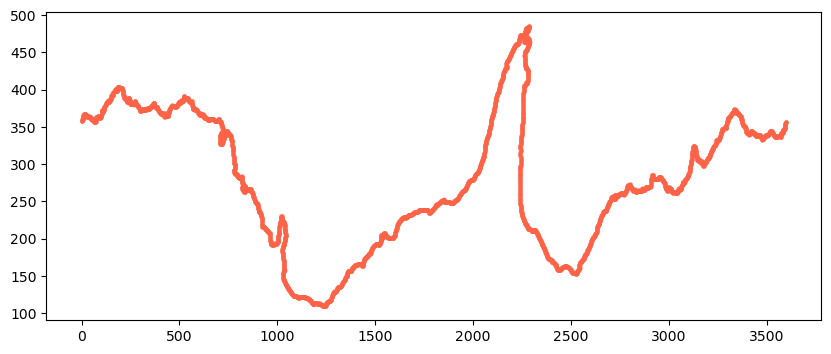

In [11]:
last_contour_index = np.where(np.abs(np.diff(x_vertices).astype(int)) > 1)[0][0]

x_contour = x_vertices[:last_contour_index + 1]
y_contour = y_vertices[:last_contour_index + 1]

# Check desired contour looks right:
fig = plt.figure(figsize = (10, 4))
plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');

`x_contour` and `y_contour` are not integers with this updated contour method.
We need to convert them to integers so we can use them as indices for selecting data on the contour.


In [12]:
x_contour = np.round(x_contour).astype(int)
y_contour = np.round(y_contour).astype(int)

# check that the difference between coords of contour never increase by more than 1:
if np.max(np.abs(np.diff(x_contour))) != 1:
    print('help! x_contour increases by more than 1 between coords.')

if np.max(np.abs(np.diff(y_contour))) != 1:
    print('help! y_contour increases by more than 1 between coords.')

#### Processing
Now process these coordinates to make sure there are no double ups.

In [13]:
contours = np.stack([x_contour, y_contour], axis=1)
print(f"Contour array size (with duplicates): {contours.shape}")
contour = np.unique(contours, axis=0)
print(f"Contour array size (post removing duplicates): {contour.shape}")

x_contour = contour[:,0]
y_contour = contour[:,1]

Contour array size (with duplicates): (6061, 2)
Contour array size (post removing duplicates): (4475, 2)


In [14]:
ht_contour = np.zeros(len(x_contour))

for ii in range(len(ht_contour)):
    ht_contour[ii] = ht[y_contour[ii], x_contour[ii]]

Due to the discrete grid, the values on our contour are not exactly the same. We check this makes sense -- if this plot is blank, then something has gone wrong.

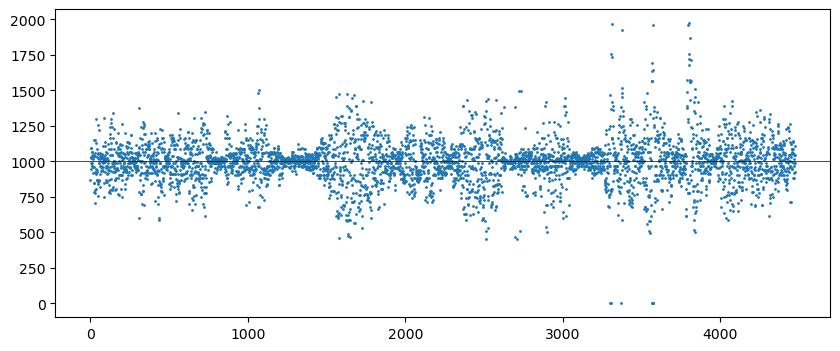

In [15]:
fig = plt.figure(figsize=(10, 4))

plt.plot(ht_contour, 'o', markersize=1)
plt.axhline(contour_depth, color='k', linewidth=0.5);

In [16]:
# Number of grid points on the contour
num_points = len(x_contour)

#### Now we number the points along the contour

In [17]:
# start numbering from 1 not 0:
contour_mask_numbered = np.arange(1, len(x_contour)+1)

In [18]:
contour_mask = xr.zeros_like(ht)

for ii in range(num_points):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]

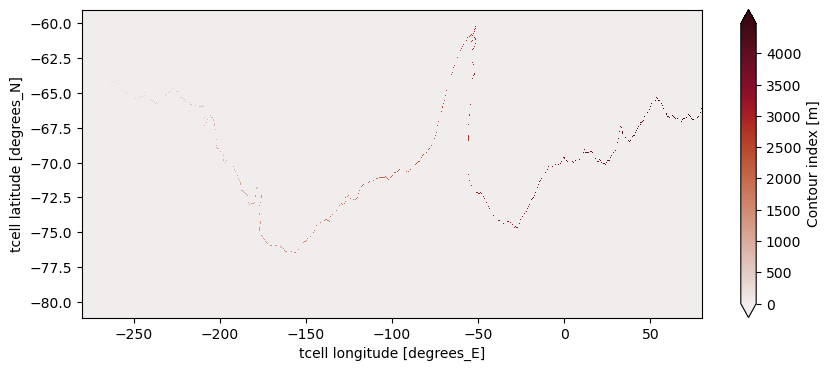

In [19]:
contour_mask.attrs['long_name'] = 'Contour index'
plt.figure(1, figsize=(10, 4))
contour_mask.plot(extend='both', cmap = cmocean.cm.amp);

#### Create mask
Now we create a mask below contour so that the direction of the contour can be determined

In [20]:
%%time

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

#from top right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0:
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask.xt_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0:
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask.xt_ocean)-1):
    for jj in range(len(contour_mask.yt_ocean)-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0:
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0:
                contour_masked_above[jj, ii+1] = mask_value

CPU times: user 30 s, sys: 293 ms, total: 30.3 s
Wall time: 30.1 s


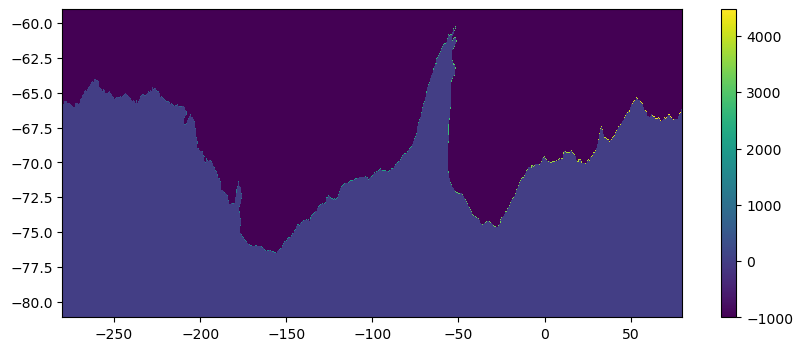

In [21]:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, contour_masked_above)
plt.colorbar()

North of the contour, values have been filled in to be -1000, and it is thus a different colour in the plot.

#### Direction of cross-contour transport
Now we can use the mask to determine whether the transport across the contour should be north, east, south or west (the grid is made of discrete square(ish) shaped cells). This is done by looping through the contour points and determining in which directions there are zeros (i.e. below contour) and -1000 (i.e. above contour). This means the orientation of the contour can be determined. This is saved as `mask_x_transport`, which has -1 and +1 in a 2D (x and y) array where the contour has eastward transport, and `mask_y_transport` which as -1 and +1 for coordinates with northward transport. All other positions in the array are 0. This means that multiplying the northward transport `ty_trans` by the `mask_y_transport` gives all the northward transport across the contour, and zeros everywhere else (e.g. where contour goes upwards and cross-contour transport is thus eastward).

In [22]:
%%time
mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos:
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do 
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point below and point above are BOTH towards Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]==0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport[index_j, index_i] = -1        
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        mask_y_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1
    # if point to left and right BOTH toward Antarctica
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]==0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport[index_j, index_i] = -1        
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        mask_x_transport_numbered[index_j, index_i] = new_number_count+1
        new_number_count += 2

CPU times: user 1min 8s, sys: 3.44 s, total: 1min 11s
Wall time: 55.4 s


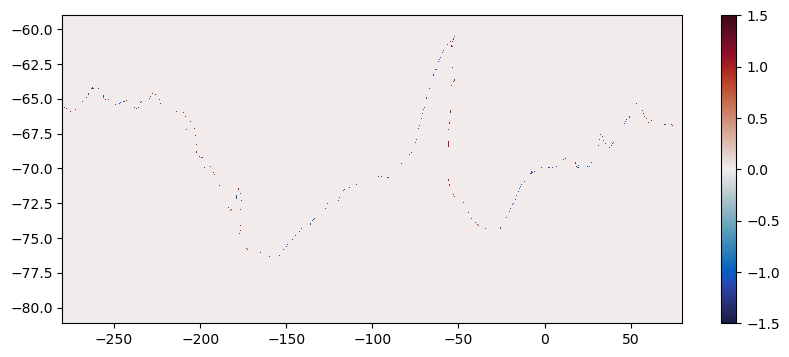

In [23]:
# Plot the mask for the x-transport:
plt.figure(1, figsize=(10, 4))

plt.pcolormesh(contour_mask.xt_ocean, contour_mask.yt_ocean, mask_x_transport,
               cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5)
plt.colorbar();

As can be seen, in `mask_x_transport` there is red (+1) where eastward transport crosses the contour, and blue (-1) where westward transport crosses the contour (in the net northward direction). There are zeros everywhere else.

### We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport. 

We now proceed to calculate transports across the contour. Here we convert the contour masks to data arrays, so we can multiply them later. We need to ensure the lat / lon coordinates correspond to the actual data location:
- The y masks are used for `ty_trans`, so like `vhrho` this should have dimensions (`yu_ocean`, `xt_ocean`).
- The x masks are used for `tx_trans`, so like `uhrho` this should have dimensions (`yt_ocean`, `xu_ocean`).

However we set the actual name to always be simply latitude/longitude irrespective of the variable to make concatenation of transports in both direction and sorting possible.

In [24]:
mask_x_transport = xr.DataArray(mask_x_transport,
                                coords = [ht.yt_ocean, hu.xu_ocean],
                                dims = ['latitude', 'longitude'])
mask_y_transport = xr.DataArray(mask_y_transport,
                                coords = [hu.yu_ocean, ht.xt_ocean],
                                dims = ['latitude', 'longitude'])
mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered,
                                         coords = [ht.yt_ocean, hu.xu_ocean],
                                         dims = ['latitude', 'longitude'])
mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered,
                                         coords = [hu.yu_ocean, ht.xt_ocean],
                                         dims = ['latitude', 'longitude'])

And plot just to confirm that we didn't mess up anything.

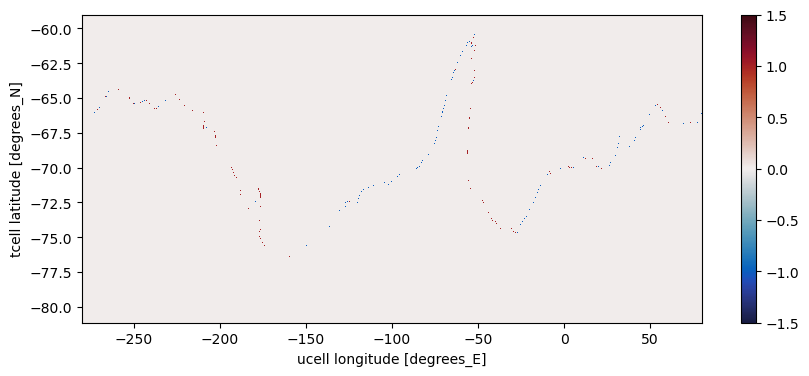

In [25]:
plt.figure(1, figsize=(10, 4))

mask_x_transport.plot(cmap=cmocean.cm.balance, vmin=-1.5, vmax=1.5);

#### Stack contour data into 1D

Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension  *names* are kept general across the counts, the generic latitude, longitude, so that concatening works but we dont double up with numerous counts for one lat/lon point.


In [26]:
# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['latitude', 'longitude'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

#### Load transports `tx_trans` and `ty_trans`

In [27]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='ty_trans', frequency="1mon")  # Can get 1mon or 3mon data
dset = var_search.to_dask(xarray_open_kwargs={'decode_timedelta' : False})
darray = dset['ty_trans']
darray = darray.sel(time=slice(start_time, end_time))
ty_trans = darray
ty_trans = ty_trans.sel(yu_ocean = lat_range, time = time_slice)
ty_trans.chunk(chunks={"time": -1})
ty_trans

<xarray.DataArray 'ty_trans' (time: 12, st_ocean: 75, yu_ocean: 510,
                              xt_ocean: 3600)> Size: 7GB
dask.array<getitem, shape=(12, 75, 510, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 96B 2170-01-16 12:00:00 ... 2170-12-16 12:00:00
  * yu_ocean  (yu_ocean) float64 4kB -81.09 -81.05 -81.0 ... -59.06 -59.01
Attributes:
    long_name:      T-cell j-mass transport
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_y_transport

These data aren't enourmous (just over 6GB), but they're not chunked very intelligently - having lots of little chunks increases multiprocessing overhead costs. We want chunks in the 100MB - 1GB range (probably towards the lower end of that range). We want to make computations, such as averaging, along the time axis, so it makes sense to keep all the time data for any position together in a chunk. However, because the input files consist of one time-step per file, we couldn't do this at load time. However, now that the data are loaded, we can do it after the fact: 

In [28]:
ty_trans = ty_trans.chunk(chunks={"time": -1, "st_ocean": -1, "yu_ocean": 102, "xt_ocean": 400})
ty_trans

<xarray.DataArray 'ty_trans' (time: 12, st_ocean: 75, yu_ocean: 510,
                              xt_ocean: 3600)> Size: 7GB
dask.array<rechunk-merge, shape=(12, 75, 510, 3600), dtype=float32, chunksize=(12, 75, 102, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) object 96B 2170-01-16 12:00:00 ... 2170-12-16 12:00:00
  * yu_ocean  (yu_ocean) float64 4kB -81.09 -81.05 -81.0 ... -59.06 -59.01
Attributes:
    long_name:      T-cell j-mass transport
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_y_transport

Now that we've worked out our chunking schema, we'll apply it to `tx_trans` as well.

In [29]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='tx_trans', frequency="1mon")
dset = var_search.to_dask(xarray_open_kwargs={'decode_timedelta' : False})
darray = dset['tx_trans']
darray = darray.sel(time=slice(start_time, end_time))
tx_trans = darray
tx_trans = tx_trans.sel(yt_ocean = lat_range, time = time_slice)
tx_trans = tx_trans.chunk(chunks={"time": -1, "st_ocean": -1, "yt_ocean": 102, "xu_ocean": 400})

ty_trans = ty_trans.rename({'yu_ocean': 'latitude', 'xt_ocean': 'longitude'})
tx_trans = tx_trans.rename({'yt_ocean': 'latitude', 'xu_ocean': 'longitude'})

tx_trans

<xarray.DataArray 'tx_trans' (time: 12, st_ocean: 75, latitude: 510,
                              longitude: 3600)> Size: 7GB
dask.array<rechunk-merge, shape=(12, 75, 510, 3600), dtype=float32, chunksize=(12, 75, 102, 400), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
  * st_ocean   (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time       (time) object 96B 2170-01-16 12:00:00 ... 2170-12-16 12:00:00
  * longitude  (longitude) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
Attributes:
    long_name:      T-cell i-mass transport
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_x_transport

#### Take time average

In [30]:
%%time

# weighed time mean by month length
days_in_month = ty_trans.time.dt.days_in_month
days_in_year = 365

tx_trans = (tx_trans * days_in_month / days_in_year).sum('time')
tx_trans = tx_trans.load()

ty_trans = (ty_trans * days_in_month / days_in_year).sum('time')
ty_trans = ty_trans.load()

CPU times: user 33.1 s, sys: 5.65 s, total: 38.7 s
Wall time: 40.5 s


#### Convert from mass transport to volume transport

In [31]:
ρ0 = 1035 # kg/m^3

ty_trans = ty_trans * mask_y_transport / ρ0 # convert kg/s -> m^3/s
tx_trans = tx_trans * mask_x_transport / ρ0 # convert kg/s -> m^3/s

#### Extract transport values along contour

In [32]:
## We could also loop in time if we didn't want the time average. 
# In that case, initialise a data array and fill in data by looping in time.

# stack transports into 1d and drop any points not on contour:
x_transport_1d = tx_trans.stack(contour_index = ['latitude', 'longitude'])
x_transport_1d = x_transport_1d.where(mask_x_numbered_1d>0, drop = True)
y_transport_1d = ty_trans.stack(contour_index = ['latitude', 'longitude'])
y_transport_1d = y_transport_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
vol_trans_across_contour = xr.concat((x_transport_1d, y_transport_1d), dim = 'contour_index')
vol_trans_across_contour = vol_trans_across_contour.sortby(contour_ordering)
vol_trans_across_contour.coords['contour_index'] = contour_index_array
vol_trans_across_contour = vol_trans_across_contour.load()

/jobfs/141517125.gadi-pbs/ipykernel_638822/2814091809.py:13: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  vol_trans_across_contour.coords['contour_index'] = contour_index_array


Plot the cumulative transport along the contour, summed over the lower part of the water column.
We can clearly see the northward dense water export in the Ross and Weddell Seas.


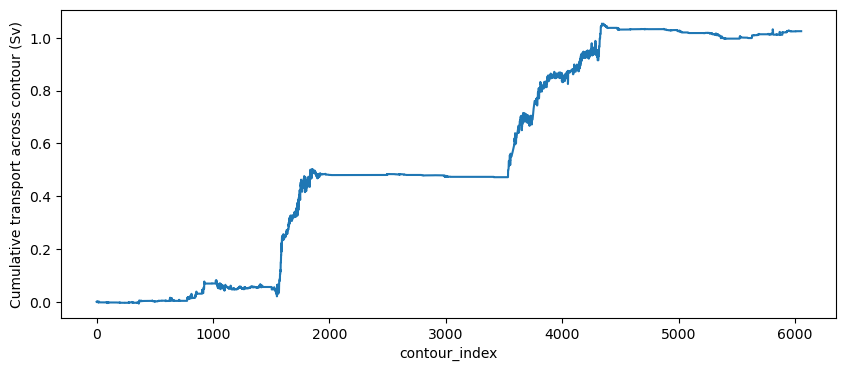

In [33]:
plt.figure(1, figsize=(10, 4))

(vol_trans_across_contour.sel(st_ocean=slice(800, 6000)).sum('st_ocean').cumsum('contour_index')/1e6).plot()
plt.ylabel('Cumulative transport across contour (Sv)');  

#### Finally, we can extract the coordinates of the contour index, and the distance, for a more meaningful $x$ axis.

In [34]:
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)

# get lat and lon along contour, useful for plotting later:
lat_along_contour = contour_ordering.latitude.copy()
lon_along_contour = contour_ordering.longitude.copy()

contour_index_array = np.arange(1, len(contour_ordering)+1)

# don't need the multi-index anymore, replace with contour count and save
lat_along_contour.coords['contour_index'] = contour_index_array
lon_along_contour.coords['contour_index'] = contour_index_array

/jobfs/141517125.gadi-pbs/ipykernel_638822/3395851563.py:11: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  lat_along_contour.coords['contour_index'] = contour_index_array
/jobfs/141517125.gadi-pbs/ipykernel_638822/3395851563.py:12: FutureWarning: updating coordinate 'contour_index' with a PandasMultiIndex would leave the multi-index level coordinates ['latitude', 'longitude'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['contour_index', 'latitude', 'longitude'])` before assigning new coordinate values.
  lon_along_contour.coords['contour_index'] = contour_index_array


#### Extract distance in between contour coordinates
This is used to label the x-axis in the plots below. Note these distances don't exactly match the dxt / dyt variables in the model, but it's only used for plotting, so it's probably ok.

In [35]:
from geopy import distance

num_points = len(lat_along_contour)
d_distance_along_contour = np.zeros((num_points))

for i in range(num_points-1):
    d_distance_along_contour[i+1] = distance.distance((lat_along_contour[i], lon_along_contour[i]), (lat_along_contour[i+1], lon_along_contour[i+1])).km

distance_along_contour = np.cumsum(d_distance_along_contour)

#### Select the indices for axis labels of specific longitudes, so we can plot transport vs distance but have longitude labels instead of length

In [36]:
target_lons = [-280, -240, -180, -120, -60, 0, 6., 80]

distance_indices = np.zeros_like(target_lons)

for j, lon in enumerate(target_lons):
    distance_indices[j] = np.argmin(np.abs((lon_along_contour.values - lon)))

#### Plot cumulative transport against distance along the contour.

In [37]:
depth_to_integrate = 800 # m

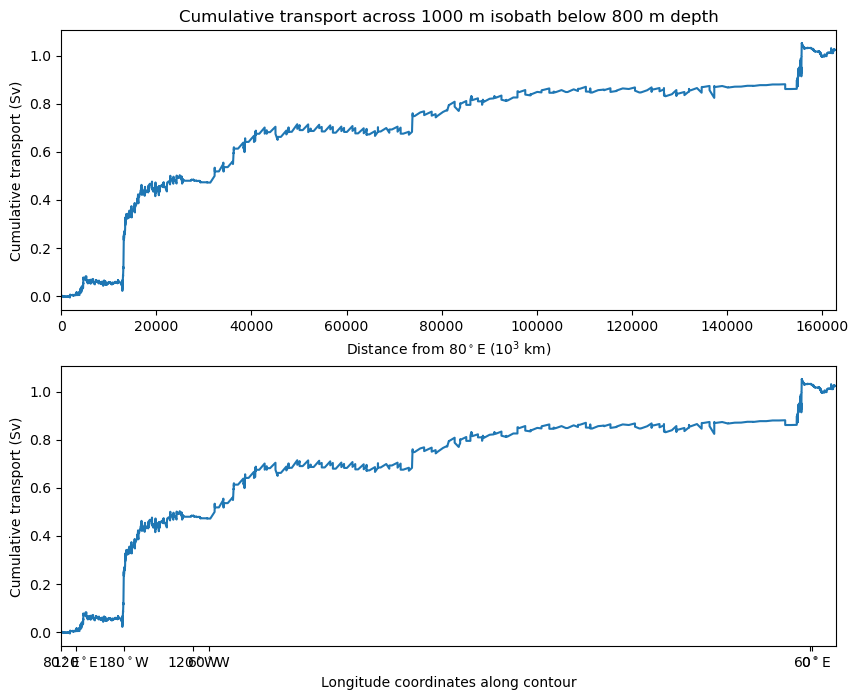

In [38]:
fig, axes = plt.subplots(nrows = 2, figsize = (10, 8))

# factor 1e-6 converts m^3/s -> Sv
axes[0].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(depth_to_integrate, 6000)).sum('st_ocean').cumsum('contour_index')))

axes[0].set_ylabel('Cumulative transport (Sv)')
axes[0].set_xlabel('Distance from 80$^\circ$E (10$^3$ km)')
axes[0].set_xlim(0, distance_along_contour[-1])
axes[0].set_title(f'Cumulative transport across {contour_depth} m isobath below {depth_to_integrate} m depth')

# factor 1e-6 converts m^3/s -> Sv
axes[1].plot(distance_along_contour, (1e-6 * vol_trans_across_contour.sel(st_ocean = slice(depth_to_integrate, 6000)).sum('st_ocean').cumsum('contour_index')))

axes[1].set_xticks(distance_along_contour[distance_indices.astype(int)[:-1]])
axes[1].set_xticklabels(('80$^\circ$E', '120$^\circ$E', '180$^\circ$W', '120$^\circ$W', '60$^\circ$W', '0$^\circ$', '60$^\circ$E'))
axes[1].set_xlim(0, distance_along_contour[-1])

axes[1].set_xlabel('Longitude coordinates along contour')
axes[1].set_ylabel('Cumulative transport (Sv)');

We can see that there is a net northward transport across the 1000m isobath on the Antarctic continental slope. This is spatially localised near the Ross and Weddell Seas where dense water is formed and exported. We could then choose to extract the density (or salt and temperature) along this same path, do this by interpolating density to the north and eastern edge of t-cells. Then we could bin the transports in each depth level into the corresponding density, to determine the transport across the contour in density space. Note this density binning needs to be done online or using at least daily data. An example of this calculation can be found in https://github.com/claireyung/Topographic_Hotspots_Upwelling-Paper_Code/blob/main/Analysis_Code/Save_and_bin_along_contours.ipynb. 